# RateML on HPC

## Use case Adaptive Exponential model usings Zerlaut equations
Lets now focus on a more complex TVB model which uses 7 states to integrate across scales using mean-field modeling of Adaptive Exponential (AdEx) neurons, explicitly incorporating intrinsic properties of excitatory and inhibitory neurons. When a realistic human connectome is used to connect the AdEx mean-field neural populations, macroscopic dynamics resembling human brain activity emerge. This model can qualitatively and quantitatively account for properties of empirical spontaneous and stimulus-evoked dynamics in the space, time, phase, and frequency domains. 

This notebook sets up the AdEx model used in these experiments and performs a GPU parameter sweep on the same parameter spaces that have been explored for these experiments namely:
- global_coupling = [0, 0.5]
- b_e = [0, 120]
- E_L_e = [-80, -60]
- E_L_i = [-80, -60]
- T = [5, 40]

The main requirement to run this notebook is an account at one of Ebrains HPC sites to access a note with a GPU at: JURECA,DAINT-CSCS, JUWELS, JUDAC, JUSUF, BSC-MareNostrum, CINECA-M100, CINECA-MARCONI or CINECA-G100.

Jennifer S. Goldman, Lionel Kusch, Bahar Hazal Yalc¸inkaya, Damien Depannemaecker, Trang-Anh E. Nghiem, Viktor Jirsa, and Alain Destexhe; A comprehensive neural simulation of slow-wave sleep and highly responsive wakefulness dynamics (2021); Unpublished, https://doi.org/10.1101/2021.08.31.458365

In [5]:
import json
import os

RML_ROOT = "/tvb-root/tvb_library/tvb/rateML/"
INSTALL_ROOT = "/opt/app-root/src/.local/lib/python3.8/site-packages/tvb/rateML/"
HERE = !pwd
HERE = str(HERE[0])
RML_HERE = HERE + RML_ROOT

### Set generated model name
This variable sets the model for simulation on HPC for this notebook. If you ever make an own .xml file for model generation with RateML, MODEL_NAME needs to be identical to its name without the ".xml" extension. For this session we will use "montbrio" and "zerlaut". 

In [ ]:
MODEL_NAME = "zerlaut"

The model we generated can be found here: rateML/generatedModels

## Simulating the generated model on HPC
If the model displays all its features to your whishes, it is time to take her for a spin on a GPU
First let setup up unicore:

In [2]:
import pyunicore.client as unicore_client

# set your account:
ACCOUNT = "put your account for an HPC site here" # [youraccount]

token = clb_oauth.get_token()
tr = unicore_client.Transport(token)
r = unicore_client.Registry(tr, unicore_client._HBP_REGISTRY_URL)
HPC_LOC = "https://zam2125.zam.kfa-juelich.de:9112/JUSUF/rest/core"
tr.preferences="group:" + ACCOUNT
site = unicore_client.Client(transport=tr,site_url=HPC_LOC)
USER = site.access_info()['xlogin']['UID']

# set up transfer (PROJECT is set by tr.preferences="group:xxx"c)
STOR_LOC = 'https://zam2125.zam.kfa-juelich.de:9112/JUDAC/rest/core'
base_url = STOR_LOC + "/storages/PROJECT/"
storage = unicore_client.Storage(tr, base_url)

site.access_info()
r.site_urls
# site.get_storages()
# r.site('JUWELS')

{'JURECA': 'https://zam2125.zam.kfa-juelich.de:9112/JURECA/rest/core',
 'DAINT-CSCS': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core',
 'JUWELS': 'https://zam2125.zam.kfa-juelich.de:9112/JUWELS/rest/core',
 'JUDAC': 'https://zam2125.zam.kfa-juelich.de:9112/JUDAC/rest/core',
 'JUSUF': 'https://zam2125.zam.kfa-juelich.de:9112/JUSUF/rest/core',
 'BSC-MareNostrum': 'https://unicore-hbp.bsc.es:8080/BSC-MareNostrum/rest/core',
 'CINECA-M100': 'https://unicore.hpc.cineca.it:9111/CINECA-M100/rest/core',
 'CINECA-MARCONI': 'https://unicore.hpc.cineca.it:9111/CINECA-MARCONI/rest/core',
 'CINECA-G100': 'https://unicore.hpc.cineca.it:9111/CINECA-G100/rest/core'}

### Setup of TVB installation remotely
Then lets setup a TVB installation on a cluster. 
First, create a setup file with all the instruction to setup TVB and load the correct modules. This file is to be transfered to your account space and execute it.

In [ ]:
with open(os.path.join(HERE, "setup.sh"), 'w') as f:                    
    account = ACCOUNT                                           
    setup = "#!/bin/bash/env bash\n" \
            "jutil env activate -p training2221 \n" \
            "git clone https://github.com/the-virtual-brain/tvb-root.git $PROJECT/$USER/tvb-root \n" \
            "export PYTHONPATH=$PYTHONPATH:$PROJECT/$USER/tvb-root/tvb_library \n" \
            "pip install tqdm --user \n" \
            "pip install tvb-data --user \n" \
            "ml Stages/2022 GCCcore/.11.2.0 \n" \
            "ml PyCUDA/2021.1 \n" \
            "ml SciPy-Stack \n" \
            "ml numba \n"
    f.write(setup)

### Transfer it

In [ ]:
source_location_bash = HERE + "/setup.sh"
source_path = os.path.join(os.environ['HOME'], source_location_bash)
storage_location_bash = "/setup.sh"
storage.upload(source_path, destination = storage_location_bash)

### Execute it

In [ ]:
# setting up the parameters sweep 
setup = {}
# setting up the environment and executing the sh file in 1 go
setup['Executable'] = "bash $PROJECT/setup.sh"
setup['RunOnLoginNode'] = "true"
setup['Job type'] = "interactive"

# submit job
setupTVB = site.new_job(job_description=setup)

setupTVB.poll()
print('Job finished!')

result_job = {}
wd = setupTVB.working_dir
result_job["stderr"] = [x.decode('utf8') for x in wd.stat("/stderr").raw().readlines()]
result_job["stdout"] = [x.decode('utf8') for x in wd.stat("/stdout").raw().readlines()]
result_job

### Transfer model
If the installation was a succes, the parameter sweep model can be transferred to the HPC site. The model is picked from the local TVB installation folder for RateML and placed remotely in the same folders.

First the model:

In [ ]:
MODLOC = "generatedModels/" + MODEL_NAME + ".c"
source_location_model = RML_HERE + MODLOC
source_path = os.path.join(os.environ['HOME'], source_location_model)
storage_location_model = USER + RML_ROOT + MODLOC
storage.upload(source_path, destination = storage_location_model)

Second the model GPU driver: (which is placed in the local installation folder only)

In [ ]:
DRVLOC = "run/model_driver_" + MODEL_NAME + ".py"
source_location_driver = RML_HERE + DRVLOC
source_path = os.path.join(os.environ['HOME'], source_location_driver)
storage_location_driver = USER + RML_ROOT + DRVLOC
storage.upload(source_path, destination = storage_location_driver)

### Job setup

Before the can be executed on HPC some other arguments need to be set:

python model_driver.py [-h] [-s0 N_SWEEP_ARG0] [-s1 N_SWEEP_ARG1] [-s2 N_SWEEP_ARG2] [-n N_TIME] [-v] [--model MODEL]
[-st STATES] [-ex EXPOSURES] [--lineinfo] [-bx BLOCKSZX] [-by BLOCKSZY] [-val] [-tvbn N_TVB_BRAINNODES] [-p] [-w] [-g]

We will set the most important ones. Many of them are already set in the driver file. 
* -s0 .. -sN arguments set the resolution of sweep paramters for the Zerlaut model:
        <Parameter name="global_coupling" dimension='0, 0.5'/>
        <Parameter name="b_e" dimension='0, 120'/>
        <Parameter name="E_L_e" dimension='-80, -60'/>
        <Parameter name="E_L_i" dimension='-80, -60'/>
        <Parameter name="T" dimension='5, 40'/>
* -n sets the simulation steps 
* -dt sets the duration of a time (integration) step
* -sm --speeds_min min speed for temporal buffer
* -v gives verbose information on the simulation
* -w writes tavg to disk


Lets setup a bash file to start the HPC parameter job. This file needs to be transferred and executed on the HPC system.
Open de jusuf.sh file to set the parameters for the model. The content should look as below. The #SBATCH parameters set the properties for HPC simulation; these should work as they are. The srun command execute the TVB HPC driver which we transferred earlier. It takes arguments for settings resolution of the parameter ranges '-s0 .. -sN', the simulation steps '-n' , duration of s single time step '-dt', minimum connection speed length to determine minimum buffer '-sm', verbose output '-v', write the output to file '-w' and set the exposure to 7 with -x7.

The next lines of code will create a job submission script:

In [19]:
with open(os.path.join(HERE, "jusuf.sh"), 'w') as f:                    
    account = ACCOUNT                                           
    batch = "#!/usr/bin/env bash \n" \
            "#SBATCH -n 1 \n" \
            "#SBATCH -N 1 \n" \
            "#SBATCH --time=01:00:00 \n" \
            "#SBATCH --partition=gpus \n" \
            f"#SBATCH --account={account} \n" \
            "#SBATCH --gres=gpu:0 \n" \
            "#SBATCH -J RateML \n" \
            "srun python $PROJECT/$USER/tvb-root/tvb_library/tvb/rateML/run/model_driver_zerlaut.py -s0 5 -s1 1 -s2 1 -s3 1 -s4 1 -n 500 -dt .1 -sm 4 -vw -x7"
    f.write(batch)

Transfer the bash file to the HPC site

In [20]:
source_location_bash = HERE + "/jusuf.sh"
source_path = os.path.join(os.environ['HOME'], source_location_bash)
storage_location_bash = USER + "/jusuf.sh"
storage.upload(source_path, destination = storage_location_bash)

Generate activation file which needs to be loaded before the submission of the driver to the GPU

In [6]:
with open(os.path.join(HERE, "activate"), 'w') as f:                    
    account = ACCOUNT                                           
    act = "#jutil env activate -p training2221 \n" \
            "ml Stages/2022 GCCcore/.11.2.0 \n" \
            "ml PyCUDA/2021.1 \n" \
            "ml SciPy-Stack \n" \
            "ml numba \n" \
            "export PYTHONPATH=$PYTHONPATH:/p/project/training2221/$USER/tvb-root/tvb_library \n"
    f.write(act)

Transfer the activation file to the HPC site

In [ ]:
source_location_bash = HERE + "/activate"
source_path = os.path.join(os.environ['HOME'], source_location_bash)
storage_location_bash = USER + "/activate"
storage.upload(source_path, destination = storage_location_bash)

### Execute the job on HPC:

#### Submit Job to selected HPC cluster 

In [14]:
my_job = {}
my_job['Executable'] = "source $PROJECT/$USER/activate; sbatch -o $PROJECT/$USER/output.out -e $PROJECT/$USER/error.er $PROJECT/$USER/jusuf.sh"
my_job['RunOnLoginNode'] = "true"
my_job['Job type'] = "interactive"

job = site.new_job(job_description=my_job)

job.poll()

result_job = {}
wd = job.working_dir
result_job["stderr"] = [x.decode('utf8') for x in wd.stat("/stderr").raw().readlines()]
result_job["stdout"] = [x.decode('utf8') for x in wd.stat("/stdout").raw().readlines()]
result_job

{'stderr': [], 'stdout': ['Submitted batch job 259286\n']}

### Info about the submitted JOB

### Fetch results
Copy the output log from cluster to Collab

In [15]:
remote = storage.stat(USER + "/output.out")
remote.download(HERE + "/data/output.out")
    
with open(HERE + "/data/output.out", "r") as f:
    for line in f:
        print (line.rstrip())

WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
   INFO  dt 0.100000
   INFO  n_nodes 68
   INFO  weights.shape (68, 68)
   INFO  lengths.shape (68, 68)
   INFO  tavg period 10.0
   INFO  n_inner_steps 100
   INFO  params shape (5, 5)
   INFO  nstep 500
   INFO  n_inner_steps 100.000000
   INFO  real buf_len 633, using power of 2 1024
   INFO  number of states 7
   INFO  model zerlaut
   INFO  real buf_len 633, using power of 2 1024
   INFO  memory for states array on GPU 9 MiB
   INFO  nvcc options ['--ptxas-options=-v', '-maxrregcount=32', '-DWARP_SIZE=32', '-DNH=1024']
   INFO  history shape (1024, 476, 5)
   INFO  gpu_data (7, 68, 5)
   INFO  on device mem: 9.386 MiB
   INFO  final block dim (8, 8, 1)
   INFO  final grid dim (1, 1)

==============NVSMI LOG==============

Timestamp                                 : Fri Jul  1 15:39:39 2022
Driver Version                            : 510.47.03
CUDA Versi

Copy the error log from JUSUF to Collab

In [ ]:
remote = storage.stat(USER + "/error.er")
remote.download(HERE + "/data/error.er")

with open(HERE + "/data/error.er", "r") as f:
    for line in f:
        print (line.rstrip())

#### Transfer the simulation results from HPC and unpickle it

In [16]:
# download the pickled results file
remote = storage.stat(USER + RML_ROOT + "/run/tavg_data")
remote.download(HERE + "/data/tavg_data")

In [17]:
import pickle
import numpy, sys

# numpy.set_printoptions(threshold=sys.maxsize)
tavg_file = open(HERE + "/data/tavg_data", 'rb')
tavg_data1 = pickle.load(tavg_file)
tavg_file.close()
# tavg_data(simsteps, states, nodes, paramscombi)
tavg_data1.shape

(500, 7, 68, 5)

### Plot the Zerlaut data

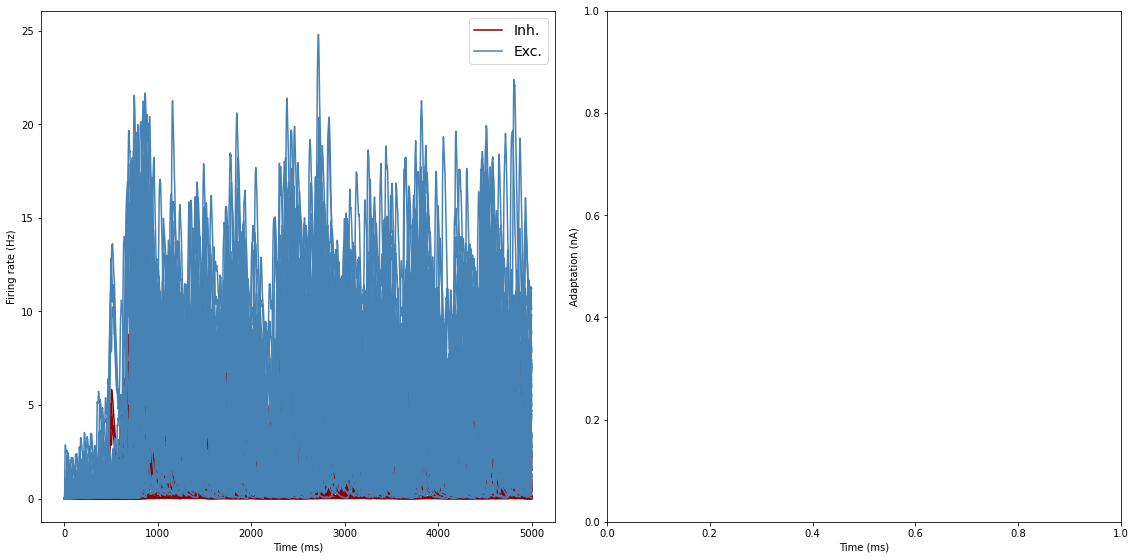

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# demo
filename = HERE + "/data/tavg_data_zerlaut_demo"
# filename = HERE + "/data/tavg_data"
tavg_file = open(filename, 'rb')
tavg_data1 = pickle.load(tavg_file)
tavg_file.close()

FR_exc = []
FR_inh = []
Ad_exc = []

n_params = 0

'''fill variables'''
# time_s = result[0][0]*1e-3 #from ms to sec
time_s = range(len(tavg_data1[:, 0, 0, 0]))
FR_exc = tavg_data1[:, 0, :, n_params]*1e3 # from KHz to Hz; Excitatory firing rate
FR_inh = tavg_data1[:, 1, :, n_params]*1e3 # from KHz to Hz; Inhibitory firing rate
# Ad_exc = tavg_data1[:, 5, :, n_params] # nA; Excitatory adaptation

fig, axes = plt.subplots(1,2,figsize=(16,8))

plt.rcParams.update({'font.size': 14})

bvals = [0]
# simname = ['asynchronous','synchronous']

for simnum in range(len(bvals)):
    
    '''plot traces'''
    Li = axes[0].plot(time_s, FR_exc,color='darkred') # [times, regions]
    Le = axes[0].plot(time_s, FR_inh,color='SteelBlue') # [times, regions]

    # axes[1].plot(time_s,Ad_exc,color='goldenrod') # [times, regions]

    axes[0].set_xlabel('Time (ms)')
    axes[1].set_xlabel('Time (ms)')

    axes[0].set_ylabel('Firing rate (Hz)')
    axes[1].set_ylabel('Adaptation (nA)')

    # axes[0].set_ylim([-15,40])
    axes[0].legend([Li[0], Le[0]], ['Inh.','Exc.'], loc='best')
    
    # for ax in axes.reshape(-1):
    #     ax.set_xlim([3,5])
    #     ax.set_xticks([3,3.5,4,4.5,5])

plt.tight_layout()
plt.show()
